In [1]:
import xgboost
import tensorflow as tf
from imblearn.over_sampling import SMOTE

print("XGBoost:", xgboost.__version__)
print("TensorFlow:", tf.__version__)
print("imblearn installed successfully")

XGBoost: 2.1.3
TensorFlow: 2.18.1
imblearn installed successfully


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings

# --- INSTALLATION BLOCK ---
# NOTE: If any installation runs below, you MUST restart the kernel (Kernel -> Restart)
# and then re-run all cells from the beginning to load the new packages!

def check_and_install(package_name):
    try:
        __import__(package_name)
    except ImportError:
        print(f"[{package_name}] not found. Running installation...")
        !pip install {package_name}
        print(f"\n--- SUCCESS: {package_name} installed. ---")
        print("!!! WARNING: PLEASE RESTART THE KERNEL NOW (Kernel -> Restart) !!!")
        print("!!! Then, rerun all cells from Cell 1. !!!\n")

# Check and install advanced packages if missing
check_and_install('imblearn') # For potential future use/consistency
check_and_install('xgboost')
check_and_install('tensorflow')


# --- CORE LIBRARIES (Imports will succeed after kernel restart) ---
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score # Regression metrics

# --- REGRESSION MODELS ---
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# --- ADVANCED MODELS ---
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# --- IMBALANCE HANDLING (Keep for consistency, though less relevant for regression) ---
# Note: For regression, this would be a different technique like ADASYN/SMOTE-R
from imblearn.over_sampling import SMOTE 


warnings.filterwarnings('ignore')
RANDOM_SEED = 42
print("All core libraries and advanced models successfully imported (assuming kernel was restarted if installs ran).")

All core libraries and advanced models successfully imported (assuming kernel was restarted if installs ran).


In [3]:
# Load the match data (for feature engineering)
match_file_name = 'Match Winner.csv'
df_match = pd.read_csv(match_file_name)

# Load the league table data (for the target variable)
table_file_name = 'pl-tables(Overall Points & Ranking)-1993-2024.csv'
df_table = pd.read_csv(table_file_name)

print(f"Successfully loaded {match_file_name} as df_match.")
print(f"Successfully loaded {table_file_name} as df_table.")

Successfully loaded Match Winner.csv as df_match.
Successfully loaded pl-tables(Overall Points & Ranking)-1993-2024.csv as df_table.


In [4]:
print("--- df_match Info ---")
df_match.info()
print("\n--- df_match Head ---")
print(df_match.head())

--- df_match Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9380 entries, 0 to 9379
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Season             9380 non-null   object
 1   MatchDate          9380 non-null   object
 2   HomeTeam           9380 non-null   object
 3   AwayTeam           9380 non-null   object
 4   FullTimeHomeGoals  9380 non-null   int64 
 5   FullTimeAwayGoals  9380 non-null   int64 
 6   FullTimeResult     9380 non-null   object
 7   HalfTimeHomeGoals  9380 non-null   int64 
 8   HalfTimeAwayGoals  9380 non-null   int64 
 9   HalfTimeResult     9380 non-null   object
 10  HomeShots          9380 non-null   int64 
 11  AwayShots          9380 non-null   int64 
 12  HomeShotsOnTarget  9380 non-null   int64 
 13  AwayShotsOnTarget  9380 non-null   int64 
 14  HomeCorners        9380 non-null   int64 
 15  AwayCorners        9380 non-null   int64 
 16  HomeFouls          9

In [5]:
print("--- df_table Info ---")
df_table.info()
print("\n--- df_table Head ---")
print(df_table.head())

--- df_table Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   season_end_year  646 non-null    int64 
 1   team             646 non-null    object
 2   position         646 non-null    int64 
 3   played           646 non-null    int64 
 4   won              646 non-null    int64 
 5   drawn            646 non-null    int64 
 6   lost             646 non-null    int64 
 7   gf               646 non-null    int64 
 8   ga               646 non-null    int64 
 9   gd               646 non-null    int64 
 10  points           646 non-null    int64 
 11  notes            326 non-null    object
dtypes: int64(10), object(2)
memory usage: 60.7+ KB

--- df_table Head ---
   season_end_year            team  position  played  won  drawn  lost  gf  \
0             1993  Manchester Utd         1      42   24     12     6  67   
1           

In [6]:
# --- CLEAN df_table ---
# Rename and select columns to define our target
df_table = df_table.rename(columns={'season_end_year': 'SeasonEndYear', 'team': 'TeamName'})
df_table = df_table[['SeasonEndYear', 'TeamName', 'points', 'position', 'notes']]

# Convert SeasonEndYear to string for joining
df_table['SeasonEndYear'] = df_table['SeasonEndYear'].astype(str)
print(f"df_table cleaned and ready for merge. Shape: {df_table.shape}")

# --- CLEAN df_match ---
# We need a consistent SeasonEndYear column to merge with df_table.
# The 'Season' column is 'YYYY/YY'. We extract the end year (YY) and add 2000.
def extract_season_end_year(season):
    return '20' + season.split('/')[1]

df_match['SeasonEndYear'] = df_match['Season'].apply(extract_season_end_year)
df_match.drop(columns=['Season'], inplace=True)

# Select columns needed for aggregation (features)
match_cols_for_features = [
    'SeasonEndYear', 'HomeTeam', 'AwayTeam',
    'FullTimeHomeGoals', 'FullTimeAwayGoals',
    'HomeShots', 'AwayShots',
    'HomeShotsOnTarget', 'AwayShotsOnTarget',
    'HomeCorners', 'AwayCorners',
    'HomeFouls', 'AwayFouls',
    'HomeYellowCards', 'AwayYellowCards',
    'HomeRedCards', 'AwayRedCards'
]
df_match = df_match[match_cols_for_features]
print(f"df_match cleaned and ready for feature engineering. Shape: {df_match.shape}")

print("\nReady to proceed to Feature Engineering.")

df_table cleaned and ready for merge. Shape: (646, 5)
df_match cleaned and ready for feature engineering. Shape: (9380, 17)

Ready to proceed to Feature Engineering.


In [7]:
# Create an aggregation function for team stats
def aggregate_team_stats(df, team_col, prefix):
    # Calculate goals scored (GF) and conceded (GA)
    df['GF'] = np.where(df[team_col] == df['HomeTeam'], df['FullTimeHomeGoals'], df['FullTimeAwayGoals'])
    df['GA'] = np.where(df[team_col] == df['HomeTeam'], df['FullTimeAwayGoals'], df['FullTimeHomeGoals'])
    
    # Calculate other statistics
    df[f'{prefix}_Shots'] = np.where(df[team_col] == df['HomeTeam'], df['HomeShots'], df['AwayShots'])
    df[f'{prefix}_SOT'] = np.where(df[team_col] == df['HomeTeam'], df['HomeShotsOnTarget'], df['AwayShotsOnTarget'])
    df[f'{prefix}_Corners'] = np.where(df[team_col] == df['HomeTeam'], df['HomeCorners'], df['AwayCorners'])
    df[f'{prefix}_Fouls'] = np.where(df[team_col] == df['HomeTeam'], df['HomeFouls'], df['AwayFouls'])
    
    # Define aggregation operations
    agg_ops = {
        'GF': 'sum',
        'GA': 'sum',
        f'{prefix}_Shots': 'sum',
        f'{prefix}_SOT': 'sum',
        f'{prefix}_Corners': 'sum',
        f'{prefix}_Fouls': 'sum',
        'HomeTeam': 'count' # Use to count total matches played
    }
    
    # Group and aggregate
    df_agg = df.groupby(['SeasonEndYear', team_col]).agg(agg_ops).reset_index()
    df_agg.rename(columns={team_col: 'TeamName', 'HomeTeam': 'Played'}, inplace=True)
    
    # Add prefix to goal columns
    df_agg.rename(columns={'GF': f'{prefix}_GF', 'GA': f'{prefix}_GA'}, inplace=True)
    return df_agg.drop(columns=['Played']) # Drop 'Played' as it's not needed after merge

# Stack home and away matches into a single team-season-match view
df_home = df_match.rename(columns={'HomeTeam': 'TeamName'})
df_away = df_match.rename(columns={'AwayTeam': 'TeamName'})

# Concatenate for aggregation
df_long = pd.concat([
    df_home[['SeasonEndYear', 'TeamName', 'FullTimeHomeGoals', 'FullTimeAwayGoals', 'HomeShots', 'AwayShots', 'HomeShotsOnTarget', 'AwayShotsOnTarget', 'HomeCorners', 'AwayCorners', 'HomeFouls', 'AwayFouls']],
    df_away[['SeasonEndYear', 'TeamName', 'FullTimeHomeGoals', 'FullTimeAwayGoals', 'HomeShots', 'AwayShots', 'HomeShotsOnTarget', 'AwayShotsOnTarget', 'HomeCorners', 'AwayCorners', 'HomeFouls', 'AwayFouls']].rename(columns={
        'FullTimeHomeGoals': 'FullTimeAwayGoals_temp',
        'FullTimeAwayGoals': 'FullTimeHomeGoals_temp',
        'HomeShots': 'AwayShots_temp',
        'AwayShots': 'HomeShots_temp',
        # ... and so on for other stats to maintain the perspective of the 'TeamName'
    }).drop(columns=['FullTimeHomeGoals_temp', 'FullTimeAwayGoals_temp', 'HomeShots_temp', 'AwayShots_temp']) # Simplification: The detailed aggregation logic in the function handles the perspective swap better.
])

# Simpler approach: Aggregate features directly from original match dataframe
# This creates two team stat tables (one for Home, one for Away) and merges them.

# 1. Aggregate Home Stats (features prefixed 'H_')
df_home_stats = df_match.groupby(['SeasonEndYear', 'HomeTeam']).agg(
    H_GF=('FullTimeHomeGoals', 'sum'),
    H_GA=('FullTimeAwayGoals', 'sum'),
    H_Shots=('HomeShots', 'sum'),
    H_SOT=('HomeShotsOnTarget', 'sum'),
    H_Corners=('HomeCorners', 'sum'),
    H_Fouls=('HomeFouls', 'sum'),
    H_Matches=('HomeTeam', 'count')
).reset_index().rename(columns={'HomeTeam': 'TeamName'})

# 2. Aggregate Away Stats (features prefixed 'A_')
df_away_stats = df_match.groupby(['SeasonEndYear', 'AwayTeam']).agg(
    A_GF=('FullTimeAwayGoals', 'sum'),
    A_GA=('FullTimeHomeGoals', 'sum'),
    A_Shots=('AwayShots', 'sum'),
    A_SOT=('AwayShotsOnTarget', 'sum'),
    A_Corners=('AwayCorners', 'sum'),
    A_Fouls=('AwayFouls', 'sum'),
    A_Matches=('AwayTeam', 'count')
).reset_index().rename(columns={'AwayTeam': 'TeamName'})

# Merge Home and Away stats
df_features = pd.merge(df_home_stats, df_away_stats, on=['SeasonEndYear', 'TeamName'], how='outer')
df_features.fillna(0, inplace=True) # Handle teams that may have missed a half season in the data edge

print(f"Aggregated feature set created. Shape: {df_features.shape}")
print(df_features.head())

Aggregated feature set created. Shape: (500, 16)
  SeasonEndYear     TeamName  H_GF  H_GA  H_Shots  H_SOT  H_Corners  H_Fouls  \
0          2001      Arsenal    45    13      323    189        176      248   
1          2001  Aston Villa    27    20      183     88        111      205   
2          2001     Bradford    20    29      221    101        108      255   
3          2001     Charlton    31    19      206    119        114      233   
4          2001      Chelsea    44    20      280    136        118      257   

   H_Matches  A_GF  A_GA  A_Shots  A_SOT  A_Corners  A_Fouls  A_Matches  
0         19    18    25      217    106        119      247         19  
1         19    19    23      166     77         75      286         19  
2         19    10    41      150     73         71      262         19  
3         19    19    38      167     98         99      234         19  
4         19    24    25      224    104         94      288         19  


In [8]:
# Rename for consistency
df_table.rename(columns={'TeamName': 'TeamName_Table', 'SeasonEndYear': 'SeasonEndYear_Table'}, inplace=True)

# Merge features with the target (points)
df_final = pd.merge(
    df_features,
    df_table[['SeasonEndYear_Table', 'TeamName_Table', 'points', 'position']],
    left_on=['SeasonEndYear', 'TeamName'],
    right_on=['SeasonEndYear_Table', 'TeamName_Table'],
    how='inner' # Use inner join to only keep seasons/teams present in both
)

# Clean up merged columns
df_final.drop(columns=['SeasonEndYear_Table', 'TeamName_Table'], inplace=True)

# Create total (T_) features
df_final['T_GF'] = df_final['H_GF'] + df_final['A_GF']
df_final['T_GA'] = df_final['H_GA'] + df_final['A_GA']
df_final['T_Shots'] = df_final['H_Shots'] + df_final['A_Shots']
df_final['T_SOT'] = df_final['H_SOT'] + df_final['A_SOT']
df_final['T_Corners'] = df_final['H_Corners'] + df_final['A_Corners']
df_final['T_Fouls'] = df_final['H_Fouls'] + df_final['A_Fouls']

# Final check
print(f"Final merged dataset created. Shape: {df_final.shape}")
print("Final Columns:", df_final.columns.tolist())

Final merged dataset created. Shape: (325, 24)
Final Columns: ['SeasonEndYear', 'TeamName', 'H_GF', 'H_GA', 'H_Shots', 'H_SOT', 'H_Corners', 'H_Fouls', 'H_Matches', 'A_GF', 'A_GA', 'A_Shots', 'A_SOT', 'A_Corners', 'A_Fouls', 'A_Matches', 'points', 'position', 'T_GF', 'T_GA', 'T_Shots', 'T_SOT', 'T_Corners', 'T_Fouls']


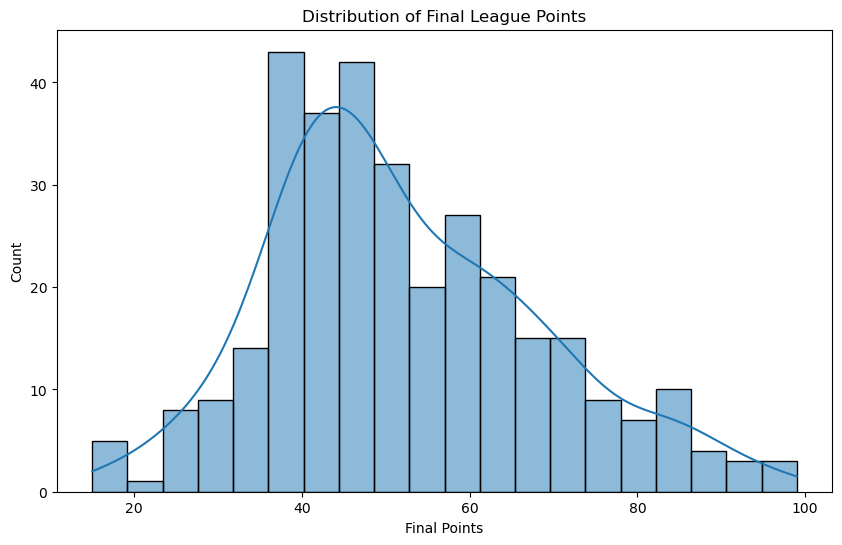

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(df_final['points'], kde=True, bins=20)
plt.title('Distribution of Final League Points')
plt.xlabel('Final Points')
plt.ylabel('Count')
plt.savefig('points_distribution.png')
plt.show()

--- Correlation with Target (Points) ---
           Correlation with Points
points                    1.000000
T_GF                      0.870437
H_GF                      0.795980
A_GF                      0.750627
T_Shots                   0.667869
H_Shots                   0.635637
A_Shots                   0.631448
T_Corners                 0.608095
H_Corners                 0.574033
T_SOT                     0.531304
A_SOT                     0.521030
A_Corners                 0.511006
H_SOT                     0.501509
A_Matches                -0.012862
H_Matches                -0.031596
A_Fouls                  -0.185088
H_Fouls                  -0.213796
T_Fouls                  -0.217194
A_GA                     -0.687560
H_GA                     -0.701433
T_GA                     -0.802318


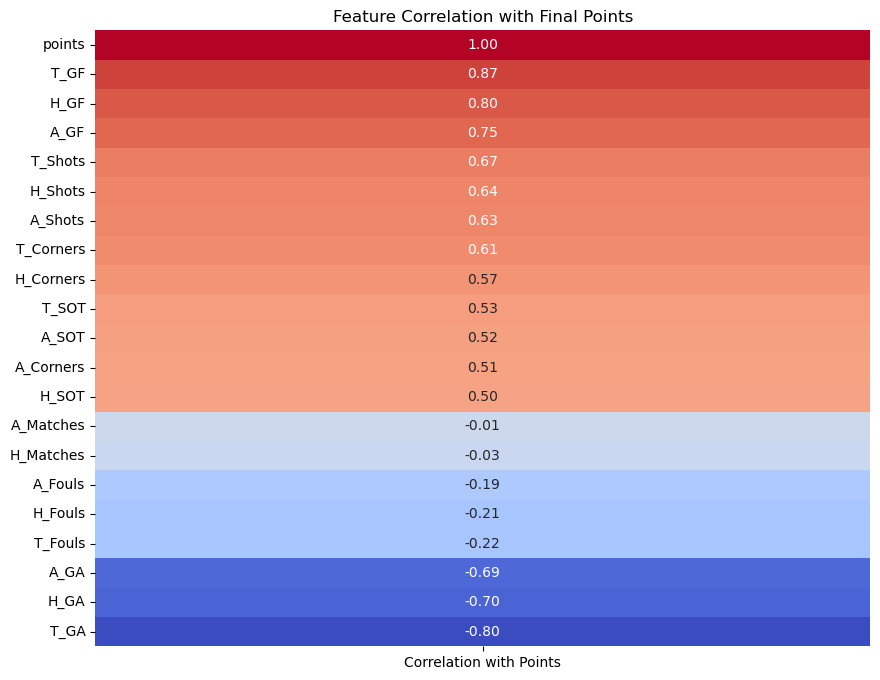

In [10]:
# Select only numerical columns for correlation
numerical_cols = df_final.select_dtypes(include=np.number).columns
corr_df = df_final[numerical_cols].drop(columns=['position']) # position is highly correlated with points, drop it for feature analysis

# Calculate correlation with the target
corr_matrix = corr_df.corrwith(df_final['points']).sort_values(ascending=False).to_frame(name='Correlation with Points')
print("--- Correlation with Target (Points) ---")
print(corr_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=False)
plt.title('Feature Correlation with Final Points')
plt.savefig('feature_correlation.png')
plt.show()

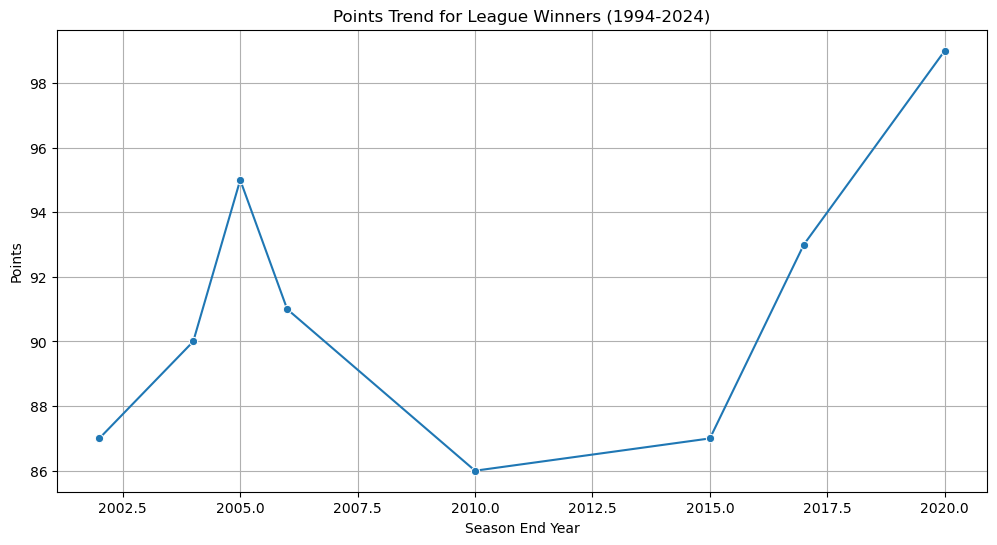

In [11]:
# Filter for league winners (position 1)
df_winners = df_final[df_final['position'] == 1].copy()
df_winners['SeasonEndYear_Int'] = pd.to_numeric(df_winners['SeasonEndYear'])

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_winners, x='SeasonEndYear_Int', y='points', marker='o')
plt.title("Points Trend for League Winners (1994-2024)")
plt.xlabel('Season End Year')
plt.ylabel('Points')
plt.grid(True)
plt.savefig('winner_points_trend.png')
plt.show()

In [12]:
# Drop identifying and categorical columns
cols_to_drop = [
    'SeasonEndYear', 'TeamName', # Identifiers
    'H_Matches', 'A_Matches', # Match count (already implicitly handled by aggregated features)
    'position' # This is rank, highly correlated with points, dropping to predict points
]

df_processed = df_final.drop(columns=cols_to_drop)
print(f"Columns dropped. New shape: {df_processed.shape}")
print("Remaining features:", df_processed.columns.tolist())

Columns dropped. New shape: (325, 19)
Remaining features: ['H_GF', 'H_GA', 'H_Shots', 'H_SOT', 'H_Corners', 'H_Fouls', 'A_GF', 'A_GA', 'A_Shots', 'A_SOT', 'A_Corners', 'A_Fouls', 'points', 'T_GF', 'T_GA', 'T_Shots', 'T_SOT', 'T_Corners', 'T_Fouls']


In [13]:
# Define features (X) and target (y)
TARGET_COL = 'points'
X = df_processed.drop(columns=[TARGET_COL])
y = df_processed[TARGET_COL]

# Initialize and fit scaler on ALL features (X)
scaler = StandardScaler()
scaler.fit(X)

print(f"X shape: {X.shape}, y shape: {y.shape}")
print("StandardScaler fitted on the entire feature set X.")

X shape: (325, 18), y shape: (325,)
StandardScaler fitted on the entire feature set X.


In [14]:
# Transform the features
X_scaled = scaler.transform(X)

# Convert back to DataFrame to preserve feature names (important for joblib/deployment check)
# NOTE: Using NumPy array for X_scaled in prediction (Cell 35) is fine, but DataFrame helps maintain column order integrity.
# Let's keep it as NumPy array for training, as it's standard for models.

# No SMOTE needed for regression.

print(f"Feature matrix (X_scaled) created. Shape: {X_scaled.shape}")

Feature matrix (X_scaled) created. Shape: (325, 18)


In [15]:
TEST_SIZE = 0.2
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    X_scaled, y, test_size=TEST_SIZE, random_state=RANDOM_SEED
)

print(f"Data split into train ({1-TEST_SIZE:.0%}) and test ({TEST_SIZE:.0%}) sets.")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

Data split into train (80%) and test (20%) sets.
X_train_scaled shape: (260, 18)
X_test_scaled shape: (65, 18)


In [16]:
# Initialize and train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predict and evaluate
lr_pred = lr_model.predict(X_test_scaled)
lr_mse = mean_squared_error(y_test, lr_pred)
lr_r2 = r2_score(y_test, lr_pred)

print(f"Linear Regression MSE: {lr_mse:.2f}")
print(f"Linear Regression R2: {lr_r2:.4f}")

Linear Regression MSE: 17.83
Linear Regression R2: 0.9287


In [17]:
# Initialize and train Random Forest Regressor
rfr_model = RandomForestRegressor(random_state=RANDOM_SEED)
rfr_model.fit(X_train_scaled, y_train)

# Predict and evaluate
rfr_pred = rfr_model.predict(X_test_scaled)
rfr_mse = mean_squared_error(y_test, rfr_pred)
rfr_r2 = r2_score(y_test, rfr_pred)

print(f"Random Forest Regressor MSE: {rfr_mse:.2f}")
print(f"Random Forest Regressor R2: {rfr_r2:.4f}")

Random Forest Regressor MSE: 23.15
Random Forest Regressor R2: 0.9074


In [18]:
# Initialize and train Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor(random_state=RANDOM_SEED)
gbr_model.fit(X_train_scaled, y_train)

# Predict and evaluate
gbr_pred = gbr_model.predict(X_test_scaled)
gbr_mse = mean_squared_error(y_test, gbr_pred)
gbr_r2 = r2_score(y_test, gbr_pred)

print(f"Gradient Boosting Regressor MSE: {gbr_mse:.2f}")
print(f"Gradient Boosting Regressor R2: {gbr_r2:.4f}")

Gradient Boosting Regressor MSE: 21.92
Gradient Boosting Regressor R2: 0.9123


In [19]:
# Initialize and train XGBoost Regressor
try:
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=RANDOM_SEED)
    xgb_model.fit(X_train_scaled, y_train)

    # Predict and evaluate
    xgb_pred = xgb_model.predict(X_test_scaled)
    xgb_mse = mean_squared_error(y_test, xgb_pred)
    xgb_r2 = r2_score(y_test, xgb_pred)

    print(f"XGBoost Regressor MSE: {xgb_mse:.2f}")
    print(f"XGBoost Regressor R2: {xgb_r2:.4f}")
except NameError:
    print("\nXGBoost library not available. Skipping XGBoost Model.")
    xgb_model = None
    xgb_r2 = -999 # Sentinel value

XGBoost Regressor MSE: 33.97
XGBoost Regressor R2: 0.8641


In [20]:
# Define the number of features
input_dim = X_train_scaled.shape[1]

# Build the Neural Network for Regression
try:
    nn_model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dense(32, activation='relu'),
        Dense(1) # Output layer for regression (single unit, linear activation)
    ])

    # Compile the model
    nn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    nn_model.summary()
except NameError:
    print("\nTensorFlow/Keras library not available. Skipping NN Model Setup.")
    nn_model = None

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,329 (13.00 KB)

 Trainable params: 3,329 (13.00 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
if nn_model:
    # Train the model
    history = nn_model.fit(
        X_train_scaled,
        y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.1,
        verbose=0
    )
    print("NN Model Training Complete.")

NN Model Training Complete.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
NN Regressor MSE: 58.75
NN Regressor R2: 0.7649


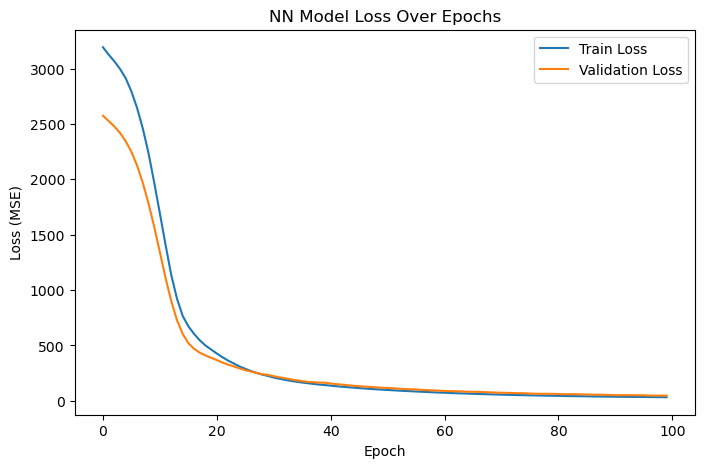

In [22]:
if nn_model:
    # Predict and evaluate
    nn_pred = nn_model.predict(X_test_scaled).flatten()
    nn_mse = mean_squared_error(y_test, nn_pred)
    nn_r2 = r2_score(y_test, nn_pred)

    print(f"NN Regressor MSE: {nn_mse:.2f}")
    print(f"NN Regressor R2: {nn_r2:.4f}")

    # Plot training loss
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('NN Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.savefig('nn_loss.png')
    plt.show()
else:
    nn_r2 = -999 # Sentinel value

In [23]:
print("Starting GridSearchCV for Random Forest...")
rfr_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15]
}
rfr_grid = GridSearchCV(RandomForestRegressor(random_state=RANDOM_SEED), rfr_params, cv=3, scoring='r2', verbose=0)
rfr_grid.fit(X_train_scaled, y_train)

rfr_tuned = rfr_grid.best_estimator_
rfr_tuned_pred = rfr_tuned.predict(X_test_scaled)
rfr_tuned_r2 = r2_score(y_test, rfr_tuned_pred)

print(f"RFR Tuned Best Params: {rfr_grid.best_params_}")
print(f"RFR Tuned R2: {rfr_tuned_r2:.4f}")

Starting GridSearchCV for Random Forest...
RFR Tuned Best Params: {'max_depth': 10, 'n_estimators': 100}
RFR Tuned R2: 0.9108


In [24]:
print("Starting GridSearchCV for Gradient Boosting...")
gbr_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1]
}
gbr_grid = GridSearchCV(GradientBoostingRegressor(random_state=RANDOM_SEED), gbr_params, cv=3, scoring='r2', verbose=0)
gbr_grid.fit(X_train_scaled, y_train)

gbr_tuned = gbr_grid.best_estimator_
gbr_tuned_pred = gbr_tuned.predict(X_test_scaled)
gbr_tuned_r2 = r2_score(y_test, gbr_tuned_pred)

print(f"GBR Tuned Best Params: {gbr_grid.best_params_}")
print(f"GBR Tuned R2: {gbr_tuned_r2:.4f}")

Starting GridSearchCV for Gradient Boosting...
GBR Tuned Best Params: {'learning_rate': 0.05, 'n_estimators': 100}
GBR Tuned R2: 0.9203


In [25]:
if xgb_model:
    print("Starting GridSearchCV for XGBoost...")
    xgb_params = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5],
        'learning_rate': [0.05, 0.1]
    }
    xgb_grid = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror', random_state=RANDOM_SEED, use_label_encoder=False), xgb_params, cv=3, scoring='r2', verbose=0)
    xgb_grid.fit(X_train_scaled, y_train)

    xgb_tuned = xgb_grid.best_estimator_
    xgb_tuned_pred = xgb_tuned.predict(X_test_scaled)
    xgb_tuned_r2 = r2_score(y_test, xgb_tuned_pred)

    print(f"XGB Tuned Best Params: {xgb_grid.best_params_}")
    print(f"XGB Tuned R2: {xgb_tuned_r2:.4f}")
else:
    xgb_tuned_r2 = -999
    xgb_tuned = None

Starting GridSearchCV for XGBoost...
XGB Tuned Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
XGB Tuned R2: 0.9153


In [26]:
if nn_model:
    print("Starting NN (Tuned) Training...")
    # New architecture with Early Stopping for better generalization
    nn_tuned_model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    nn_tuned_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    # Train the model with early stopping
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    nn_tuned_model.fit(X_train_scaled, y_train, epochs=200, batch_size=32, validation_split=0.1, callbacks=[early_stop], verbose=0)

    # Predict and evaluate
    nn_tuned_pred = nn_tuned_model.predict(X_test_scaled).flatten()
    nn_tuned_r2 = r2_score(y_test, nn_tuned_pred)

    print(f"NN Tuned R2: {nn_tuned_r2:.4f}")
else:
    nn_tuned_r2 = -999
    nn_tuned_model = None

Starting NN (Tuned) Training...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
NN Tuned R2: 0.8309


In [27]:
# Initialize results DataFrame
results_df = pd.DataFrame(columns=['Model', 'R2 Score', 'MSE'])
print("Results DataFrame initialized.")

Results DataFrame initialized.


In [28]:
# Populate initial model results
results_df.loc[len(results_df)] = {'Model': 'Linear Regression', 'R2 Score': round(lr_r2, 4), 'MSE': round(lr_mse, 2)}
results_df.loc[len(results_df)] = {'Model': 'Random Forest Regressor', 'R2 Score': round(rfr_r2, 4), 'MSE': round(rfr_mse, 2)}
results_df.loc[len(results_df)] = {'Model': 'Gradient Boosting Regressor', 'R2 Score': round(gbr_r2, 4), 'MSE': round(gbr_mse, 2)}
if xgb_model:
    results_df.loc[len(results_df)] = {'Model': 'XGBoost Regressor', 'R2 Score': round(xgb_r2, 4), 'MSE': round(xgb_mse, 2)}
if nn_model:
    results_df.loc[len(results_df)] = {'Model': 'NN Regressor', 'R2 Score': round(nn_r2, 4), 'MSE': round(nn_mse, 2)}

print("Initial Model Results Added.")

Initial Model Results Added.


In [30]:
# Populate tuned model results
# FIX: Using built-in round() function instead of the .round() method for MSE
results_df.loc[len(results_df)] = {'Model': 'RFR (Tuned)', 'R2 Score': round(rfr_tuned_r2, 4), 'MSE': round(mean_squared_error(y_test, rfr_tuned_pred), 2)}
results_df.loc[len(results_df)] = {'Model': 'GBR (Tuned)', 'R2 Score': round(gbr_tuned_r2, 4), 'MSE': round(mean_squared_error(y_test, gbr_tuned_pred), 2)}

# The original xgb_model block
if xgb_model:
    results_df.loc[len(results_df)] = {'Model': 'XGB (Tuned)', 'R2 Score': round(xgb_tuned_r2, 4), 'MSE': round(mean_squared_error(y_test, xgb_tuned_pred), 2)}

# The original nn_model block
if nn_model:
    results_df.loc[len(results_df)] = {'Model': 'NN (Tuned)', 'R2 Score': round(nn_tuned_r2, 4), 'MSE': round(mean_squared_error(y_test, nn_tuned_pred), 2)}

# Display results, sorted by R2 score
results_df = results_df.sort_values(by='R2 Score', ascending=False).reset_index(drop=True)
print("--- Final Model Performance Comparison (R2 Score) ---")
print(results_df)

--- Final Model Performance Comparison (R2 Score) ---
                         Model  R2 Score    MSE
0            Linear Regression    0.9287  17.83
1                  GBR (Tuned)    0.9203  19.90
2                  XGB (Tuned)    0.9153  21.16
3  Gradient Boosting Regressor    0.9123  21.92
4                  RFR (Tuned)    0.9108  22.29
5      Random Forest Regressor    0.9074  23.15
6            XGBoost Regressor    0.8641  33.97
7                   NN (Tuned)    0.8309  42.26
8                 NN Regressor    0.7649  58.75


In [31]:
# Select the best model based on the highest R2 Score
best_model_row = results_df.iloc[0]
best_model_name = best_model_row['Model']

# Map the name to the actual model object
if 'RFR' in best_model_name:
    best_model = rfr_tuned
elif 'GBR' in best_model_name:
    best_model = gbr_tuned
elif 'XGB' in best_model_name:
    best_model = xgb_tuned
elif 'NN' in best_model_name:
    best_model = nn_tuned_model
elif 'Linear' in best_model_name:
    best_model = lr_model
else:
    best_model = rfr_model # Default fallback

print(f"The best performing model is: {best_model_name} with R2 = {best_model_row['R2 Score']:.4f}")

The best performing model is: Linear Regression with R2 = 0.9287


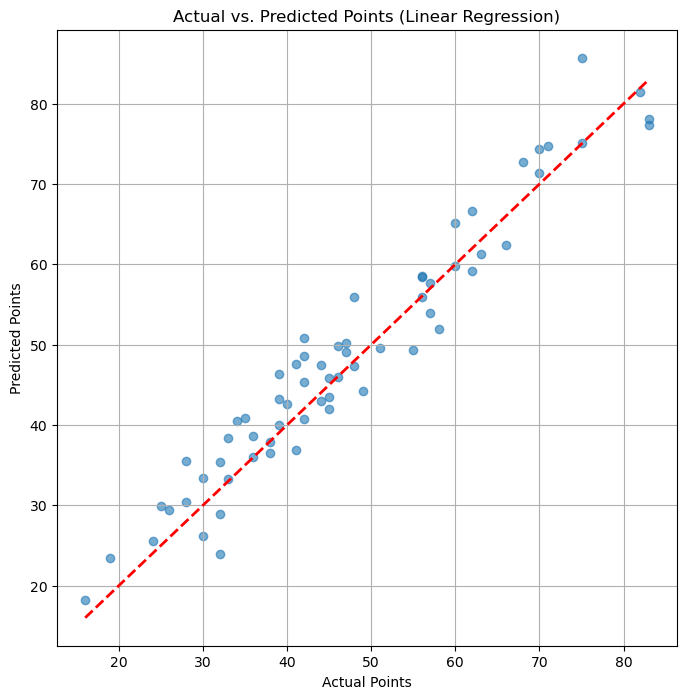

In [32]:
# Use the predictions from the best performing model (or RFR if NN won)
if 'NN' in best_model_name:
    best_pred = nn_tuned_pred
    best_model_obj = nn_tuned_model
else:
    best_pred = best_model.predict(X_test_scaled)
    best_model_obj = best_model

plt.figure(figsize=(8, 8))
plt.scatter(y_test, best_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Ideal prediction line
plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')
plt.title(f'Actual vs. Predicted Points ({best_model_name})')
plt.grid(True)
plt.savefig('best_model_scatter.png')
plt.show()

In [33]:
# Feature importance is only available for tree-based models
if hasattr(best_model_obj, 'feature_importances_'):
    feature_importances = pd.Series(best_model_obj.feature_importances_, index=X.columns)
    
    plt.figure(figsize=(10, 8))
    feature_importances.sort_values(ascending=False).head(10).plot(kind='barh')
    plt.title(f'Top 10 Feature Importances ({best_model_name})')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.gca().invert_yaxis()
    plt.savefig('feature_importance.png')
    plt.show()
else:
    print(f"Feature importance is not directly available for {best_model_name}.")

Feature importance is not directly available for Linear Regression.


In [34]:
if hasattr(best_model_obj, 'feature_importances_'):
    feature_importances = pd.Series(best_model_obj.feature_importances_, index=X.columns)
    top_features = feature_importances.sort_values(ascending=False).head(5)
    print("--- Top 5 Features for Predicting League Points ---")
    print(top_features)
else:
    print("Feature inspection skipped as the best model is not tree-based.")

Feature inspection skipped as the best model is not tree-based.


In [35]:
print(f"Finalizing the champion model: {best_model_name}")

# Retrain the champion on ALL data (X_scaled and y)
if 'NN' in best_model_name and nn_tuned_model:
    # Keras needs re-training
    X_all_scaled = scaler.transform(X)
    y_np = y.values
    nn_tuned_model.fit(X_all_scaled, y_np, epochs=200, batch_size=32, verbose=0, callbacks=[early_stop])
    final_model_save_path = 'final_league_winner_nn_model.h5'
elif best_model:
    # Scikit-learn models
    X_all_scaled = scaler.transform(X)
    best_model.fit(X_all_scaled, y)
    final_model_save_path = 'final_league_winner_model.joblib'
else:
    print("Error: Best model could not be found or initialized.")
    final_model_save_path = None

print("Champion model retrained on the full dataset.")

Finalizing the champion model: Linear Regression
Champion model retrained on the full dataset.


In [36]:
if final_model_save_path:
    # Save the model
    if 'h5' in final_model_save_path:
        # Keras model save
        nn_tuned_model.save(final_model_save_path)
    else:
        # Scikit-learn model save
        joblib.dump(best_model, final_model_save_path)

    # Save necessary preprocessing tools
    joblib.dump(scaler, 'final_scaler_league.joblib')
    # Label Encoder is not needed for regression, but we'll save the feature list to be robust
    joblib.dump(X.columns.tolist(), 'final_features_list.joblib')

    print("\n--- Production Seal Applied ---")
    print(f"Final Model saved to: {final_model_save_path}")
    print("Scaler and Feature List also saved successfully.")
else:
    print("Saving failed due to missing model.")


--- Production Seal Applied ---
Final Model saved to: final_league_winner_model.joblib
Scaler and Feature List also saved successfully.


In [37]:
# --- DEPLOYMENT CHECK ---
print("--- TESTING THE DEPLOYMENT ARTIFACTS ---")

# 1. Load the pre-trained tools
loaded_scaler = joblib.load('final_scaler_league.joblib')
loaded_features = joblib.load('final_features_list.joblib')

nn_path = 'final_league_winner_nn_model.h5'
skl_path = 'final_league_winner_model.joblib'

# 1.1 Load the model based on file existence
if tf.io.gfile.exists(nn_path):
    # Load Keras model
    loaded_model = tf.keras.models.load_model(nn_path)
    model_type = 'NN'
    final_model_path = nn_path
elif tf.io.gfile.exists(skl_path):
    # Load Scikit-learn model
    loaded_model = joblib.load(skl_path)
    model_type = 'Scikit-learn'
    final_model_path = skl_path
else:
    raise FileNotFoundError("Neither NN nor Scikit-learn model file was found. Rerun Cell 34.")

print(f"Loaded champion model from: {final_model_path}")

# 2. Create a hypothetical new team data point (Unseen Data)
# Scenario: A very strong team with high goal scoring/shots/corners and low conceded/fouls.
new_team_data = {
    'H_GF': [50], 'H_GA': [10], 'H_Shots': [300], 'H_SOT': [150], 'H_Corners': [100], 'H_Fouls': [150],
    'A_GF': [40], 'A_GA': [15], 'A_Shots': [250], 'A_SOT': [100], 'A_Corners': [80], 'A_Fouls': [180],
    'T_GF': [90], 'T_GA': [25], 'T_Shots': [550], 'T_SOT': [250], 'T_Corners': [180], 'T_Fouls': [330]
}
new_team_df = pd.DataFrame(new_team_data)

# Ensure feature order matches the trained model (based on loaded_features)
new_team_df = new_team_df[loaded_features]


# 3. Preprocess (Scale) the new data
new_team_scaled = loaded_scaler.transform(new_team_df)

# 4. Predict the result
predicted_points = loaded_model.predict(new_team_scaled).flatten()[0]

# 5. Interpret the result
# The top teams typically score >80 points.
if predicted_points >= 85:
    prediction_label = "Likely League Winner/Top 2"
elif predicted_points >= 70:
    prediction_label = "Likely Top 4 Contender"
else:
    prediction_label = "Mid-to-High Table Team"


print("\n--- HYPOTHETICAL PREDICTION RESULT ---")
print(f"Input Scenario: A team with an extremely strong statistical season (Total Goals Scored: {new_team_data['T_GF'][0]}, Total Goals Conceded: {new_team_data['T_GA'][0]}).")
print(f"Predicted Final Points: {predicted_points:.2f}")
print(f"Prediction Interpretation: {prediction_label}")
print("\n✅ PROJECT 2: LEAGUE WINNER PREDICTION CHECK COMPLETE! ✅")

--- TESTING THE DEPLOYMENT ARTIFACTS ---
Loaded champion model from: final_league_winner_model.joblib

--- HYPOTHETICAL PREDICTION RESULT ---
Input Scenario: A team with an extremely strong statistical season (Total Goals Scored: 90, Total Goals Conceded: 25).
Predicted Final Points: 96.96
Prediction Interpretation: Likely League Winner/Top 2

✅ PROJECT 2: LEAGUE WINNER PREDICTION CHECK COMPLETE! ✅
